<a href="https://colab.research.google.com/github/codeslayr/Neural_Network_Optimization/blob/main/cnn_hyperparameter_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import random
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. SETUP & IMPORTS

# --- Experiment Config ---
NUM_SEARCH_TRIALS = 20
FINAL_TRAINING_EPOCHS = 10
GA_POP_SIZE = 10
GA_GENERATIONS = 20
PSO_PARTICLES = 10
PSO_GENERATIONS = 20

# --- Device & Seeding ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

def set_seeds(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seeds()

Using device: cuda


In [ ]:
# 2. DATA LOADING

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Full datasets
full_train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Split for validation
train_ds, val_ds = random_split(full_train_dataset, [55000, 5000])

# Subset for faster hyperparameter search
search_train_subset = Subset(train_ds, list(range(5000)))

# DataLoaders
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
CLASS_NAMES = test_dataset.classes

100%|██████████| 26.4M/26.4M [00:01<00:00, 15.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 303kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.52MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.1MB/s]


In [ ]:
# 3. MODEL DEFINITIONS

class FashionCNN(nn.Module):
    """Fixed architecture for Adam, SGD, L-BFGS."""
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(), nn.Linear(64 * 7 * 7, 128), nn.ReLU(), nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.net(x)

class CustomCNN(nn.Module):
    """Variable architecture for GA, PSO."""
    def __init__(self, conv1_out, conv2_out, fc_units):
        super().__init__()
        self.conv1 = nn.Conv2d(1, int(conv1_out), 3, padding=1)
        self.conv2 = nn.Conv2d(int(conv1_out), int(conv2_out), 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten_size = int(conv2_out * 7 * 7)
        self.fc1 = nn.Linear(self.flatten_size, int(fc_units))
        self.fc2 = nn.Linear(int(fc_units), 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
# 4. CORE UTILITIES

criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, dataloader, optimizer, use_closure=False, wd=0.0):
    """Trains the model for one epoch."""
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X, y in dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)

        def closure():
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            if wd > 0:
                l2_reg = sum(p.pow(2).sum() for p in model.parameters())
                loss += wd * l2_reg
            loss.backward()
            return loss

        if use_closure:
            loss = optimizer.step(closure)
        else:
            loss = closure()
            optimizer.step()

        with torch.no_grad():
            total_loss += loss.item() * y.size(0)
            preds = model(X).argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    return total_loss / total, correct / total

def evaluate_and_get_metrics(model, dataloader):
    """Evaluates the model and returns loss, accuracy, and predictions."""
    model.eval()
    all_preds, all_labels = [], []
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            out = model(X)
            loss = criterion(out, y)

            total_loss += loss.item() * y.size(0)
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / total
    avg_acc = correct / total

    report = classification_report(all_labels, all_preds, target_names=CLASS_NAMES, output_dict=True, zero_division=0)

    metrics = {
        'loss': avg_loss,
        'accuracy': avg_acc,
        'report': report,
        'y_true': all_labels,
        'y_pred': all_preds
    }
    return metrics

In [ ]:
# 5. OPTIMIZER EXPERIMENT FUNCTIONS

def run_adam_experiment():
    print("\n--- Running Adam (Baseline) ---")
    set_seeds()
    model = FashionCNN().to(DEVICE)
    # Using a less-optimal LR to show the value of hyperparameter tuning.
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    full_train_loader = DataLoader(full_train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(FINAL_TRAINING_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, full_train_loader, optimizer)
        val_metrics = evaluate_and_get_metrics(model, val_loader)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        print(f"Epoch {epoch+1}/{FINAL_TRAINING_EPOCHS} -> Train Acc: {train_acc:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")

    test_metrics = evaluate_and_get_metrics(model, test_loader)
    print(f"\n✅ Adam Final Results -> Test Loss: {test_metrics['loss']:.4f}, Test Acc: {test_metrics['accuracy']:.4f}")
    return {'model': model, 'history': history, 'test_metrics': test_metrics}

def run_sgd_experiment():
    print("\n--- Running SGD with Random Search ---")
    search_space = {
        'lr': lambda: 10**np.random.uniform(-4, -1),
        'momentum': lambda: np.random.uniform(0.5, 0.99),
        'batch_size': lambda: random.choice([32, 64, 128]),
        'weight_decay': lambda: 10**np.random.uniform(-5, -2)
    }

    # Search Phase
    print("Running search phase...")
    best_config, best_val_acc = None, -1
    val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)
    for i in range(NUM_SEARCH_TRIALS):
        set_seeds(i)
        config = {k: fn() for k, fn in search_space.items()}
        model = FashionCNN().to(DEVICE)
        optimizer = optim.SGD(model.parameters(), **{k:v for k,v in config.items() if k != 'batch_size'})
        search_loader = DataLoader(search_train_subset, batch_size=int(config['batch_size']), shuffle=True)
        train_one_epoch(model, search_loader, optimizer)
        val_metrics = evaluate_and_get_metrics(model, val_loader)
        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            best_config = config
        print(f"Trial [{i+1}/{NUM_SEARCH_TRIALS}] - Acc: {val_metrics['accuracy']:.4f}, Loss: {val_metrics['loss']:.4f}, Config: {config}")

    print(f"\nSearch complete. Best params found: {best_config}")

    # Final Training
    print("Running final training with best params...")
    set_seeds()
    model = FashionCNN().to(DEVICE)
    optimizer = optim.SGD(model.parameters(), **{k:v for k,v in best_config.items() if k != 'batch_size'})
    full_train_loader = DataLoader(full_train_dataset, batch_size=int(best_config['batch_size']), shuffle=True)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(FINAL_TRAINING_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, full_train_loader, optimizer)
        val_metrics = evaluate_and_get_metrics(model, val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        print(f"Epoch {epoch+1}/{FINAL_TRAINING_EPOCHS} -> Train Acc: {train_acc:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")

    test_metrics = evaluate_and_get_metrics(model, test_loader)
    print(f"\n✅ SGD Final Results -> Test Loss: {test_metrics['loss']:.4f}, Test Acc: {test_metrics['accuracy']:.4f}")
    return {'model': model, 'history': history, 'test_metrics': test_metrics}

def run_lbfgs_experiment():
    print("\n--- Running L-BFGS with Random Search ---")
    search_space = {
        'lr': lambda: 10**np.random.uniform(-2, 0),
        'batch_size': lambda: random.choice([256, 512, 1024]),
        'weight_decay': lambda: 10**np.random.uniform(-5, -2)
    }

    # Search Phase
    print("Running search phase...")
    best_config, best_val_acc = None, -1
    val_loader = DataLoader(val_ds, batch_size=512, shuffle=False)
    for i in range(NUM_SEARCH_TRIALS):
        set_seeds(i)
        config = {k: fn() for k, fn in search_space.items()}
        model = FashionCNN().to(DEVICE)
        optimizer = optim.LBFGS(model.parameters(), lr=config['lr'], max_iter=10)
        search_loader = DataLoader(search_train_subset, batch_size=int(config['batch_size']), shuffle=True)
        train_one_epoch(model, search_loader, optimizer, use_closure=True, wd=config['weight_decay'])
        val_metrics = evaluate_and_get_metrics(model, val_loader)
        if val_metrics['accuracy'] > best_val_acc:
            best_val_acc = val_metrics['accuracy']
            best_config = config
        print(f"Trial [{i+1}/{NUM_SEARCH_TRIALS}] - Acc: {val_metrics['accuracy']:.4f}, Loss: {val_metrics['loss']:.4f}, Config: {config}")

    print(f"\nSearch complete. Best params found: {best_config}")

    # Final Training
    print("Running final training with best params...")
    set_seeds()
    model = FashionCNN().to(DEVICE)
    full_train_loader = DataLoader(full_train_dataset, batch_size=int(best_config['batch_size']), shuffle=True)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(FINAL_TRAINING_EPOCHS):
        optimizer = optim.LBFGS(model.parameters(), lr=best_config['lr'], max_iter=20, line_search_fn="strong_wolfe")
        train_loss, train_acc = train_one_epoch(model, full_train_loader, optimizer, use_closure=True, wd=best_config['weight_decay'])
        val_metrics = evaluate_and_get_metrics(model, val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        print(f"Epoch {epoch+1}/{FINAL_TRAINING_EPOCHS} -> Train Acc: {train_acc:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")

    test_metrics = evaluate_and_get_metrics(model, test_loader)
    print(f"\n✅ L-BFGS Final Results -> Test Loss: {test_metrics['loss']:.4f}, Test Acc: {test_metrics['accuracy']:.4f}")
    return {'model': model, 'history': history, 'test_metrics': test_metrics}

def run_ga_experiment():
    print("\n--- Running Genetic Algorithm (GA) Search ---")
    param_bounds = {"lr": [1e-4, 1e-2], "conv1_out": [16, 64], "conv2_out": [32, 128], "fc_units": [64, 256]}
    def random_gene():
        return {"lr": 10**random.uniform(-4, -2), "conv1_out": random.randint(16, 64),
                "conv2_out": random.randint(32, 128), "fc_units": random.randint(64, 256)}

    # Search Phase
    print("Running search phase...")
    population = [random_gene() for _ in range(GA_POP_SIZE)]
    best_gene, best_val_acc = None, -1
    val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)
    for gen in range(GA_GENERATIONS):
        scored_pop = []
        for gene in population:
            set_seeds(gen)
            model_params = {k: gene[k] for k in ['conv1_out', 'conv2_out', 'fc_units']}
            model = CustomCNN(**model_params).to(DEVICE)
            optimizer = optim.Adam(model.parameters(), lr=gene['lr'])
            search_loader = DataLoader(search_train_subset, batch_size=64, shuffle=True)
            train_one_epoch(model, search_loader, optimizer)
            val_metrics = evaluate_and_get_metrics(model, val_loader)
            scored_pop.append({'acc': val_metrics['accuracy'], 'loss': val_metrics['loss'], 'gene': gene})

        scored_pop.sort(key=lambda x: x['acc'], reverse=True)
        best_of_gen = scored_pop[0]
        if best_of_gen['acc'] > best_val_acc:
            best_val_acc = best_of_gen['acc']
            best_gene = best_of_gen['gene']

        print(f"Gen [{gen+1}/{GA_GENERATIONS}] -> Best Acc: {best_of_gen['acc']:.4f}, Loss: {best_of_gen['loss']:.4f}, Config: {best_of_gen['gene']}")

        top_genes = [g['gene'] for g in scored_pop[:GA_POP_SIZE//2]]
        new_pop = top_genes[:]
        while len(new_pop) < GA_POP_SIZE:
            p1, p2 = random.sample(top_genes, 2)
            child = {k: p1[k] if random.random() < 0.5 else p2[k] for k in p1}
            new_pop.append(child)
        population = new_pop

    print(f"\nSearch complete. Best gene found: {best_gene}")

    # Final Training
    print("Running final training with best gene...")
    set_seeds()
    final_model_params = {k: best_gene[k] for k in ['conv1_out', 'conv2_out', 'fc_units']}
    model = CustomCNN(**final_model_params).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=best_gene['lr'])
    full_train_loader = DataLoader(full_train_dataset, batch_size=64, shuffle=True)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(FINAL_TRAINING_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, full_train_loader, optimizer)
        val_metrics = evaluate_and_get_metrics(model, val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        print(f"Epoch {epoch+1}/{FINAL_TRAINING_EPOCHS} -> Train Acc: {train_acc:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")

    test_metrics = evaluate_and_get_metrics(model, test_loader)
    print(f"\n✅ GA Final Results -> Test Loss: {test_metrics['loss']:.4f}, Test Acc: {test_metrics['accuracy']:.4f}")
    return {'model': model, 'history': history, 'test_metrics': test_metrics}

def run_pso_experiment():
    print("\n--- Running Particle Swarm Optimization (PSO) ---")
    param_bounds = {"lr": [1e-4, 1e-2], "conv1_out": [16, 64], "conv2_out": [32, 128], "fc_units": [64, 256]}
    def init_particle():
        return {"lr": 10**random.uniform(-4, -2), "conv1_out": random.uniform(16, 64),
                "conv2_out": random.uniform(32, 128), "fc_units": random.uniform(64, 256)}
    def to_int_params(p):
        return {k: (v if k == 'lr' else int(v)) for k,v in p.items()}

    # Search Phase
    print("Running search phase...")
    particles = [init_particle() for _ in range(PSO_PARTICLES)]
    velocities = [{k: 0 for k in p} for p in particles]
    personal_best_pos = deepcopy(particles)
    personal_best_scores = [float('inf')] * PSO_PARTICLES
    global_best_pos, global_best_score = None, float('inf')
    val_loader = DataLoader(val_ds, batch_size=128, shuffle=False)

    for gen in range(PSO_GENERATIONS):
        for i, p in enumerate(particles):
            int_params = to_int_params(p)
            model_params = {k: int_params[k] for k in ['conv1_out', 'conv2_out', 'fc_units']}
            model = CustomCNN(**model_params).to(DEVICE)
            optimizer = optim.Adam(model.parameters(), lr=p['lr'])
            search_loader = DataLoader(search_train_subset, batch_size=64, shuffle=True)
            train_one_epoch(model, search_loader, optimizer)
            score = evaluate_and_get_metrics(model, val_loader)['loss']
            if score < personal_best_scores[i]:
                personal_best_scores[i] = score
                personal_best_pos[i] = deepcopy(p)
            if score < global_best_score:
                global_best_score = score
                global_best_pos = deepcopy(p)

        global_best_int_params = to_int_params(global_best_pos)
        current_acc = evaluate_and_get_metrics(model, val_loader)['accuracy']
        print(f"Gen [{gen+1}/{PSO_GENERATIONS}] -> Best Acc: {current_acc:.4f}, Loss: {global_best_score:.4f}, Config: {global_best_int_params}")

        w, c1, c2 = 0.5, 1.5, 1.5
        for i, p in enumerate(particles):
            for k in p:
                r1, r2 = random.random(), random.random()
                velocities[i][k] = (w*velocities[i][k] + c1*r1*(personal_best_pos[i][k] - p[k]) + c2*r2*(global_best_pos[k] - p[k]))
                p[k] += velocities[i][k]
                p[k] = np.clip(p[k], *param_bounds[k])

    best_params = to_int_params(global_best_pos)
    print(f"\nSearch complete. Best params found: {best_params}")

    # Final Training
    print("Running final training with best params...")
    set_seeds()
    final_model_params = {k: best_params[k] for k in ['conv1_out', 'conv2_out', 'fc_units']}
    model = CustomCNN(**final_model_params).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
    full_train_loader = DataLoader(full_train_dataset, batch_size=64, shuffle=True)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(FINAL_TRAINING_EPOCHS):
        train_loss, train_acc = train_one_epoch(model, full_train_loader, optimizer)
        val_metrics = evaluate_and_get_metrics(model, val_loader)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        print(f"Epoch {epoch+1}/{FINAL_TRAINING_EPOCHS} -> Train Acc: {train_acc:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")

    test_metrics = evaluate_and_get_metrics(model, test_loader)
    print(f"\n✅ PSO Final Results -> Test Loss: {test_metrics['loss']:.4f}, Test Acc: {test_metrics['accuracy']:.4f}")
    return {'model': model, 'history': history, 'test_metrics': test_metrics}

In [ ]:
# 6. PLOTTING FUNCTIONS (REVISED)

def plot_learning_curves(results_archive):
    """Plots training & validation accuracy/loss curves for each optimizer."""
    for name, results in results_archive.items():
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f'{name} - Learning Dynamics', fontsize=16)

        history = results['history']
        epochs = range(1, len(history['train_loss']) + 1)

        # Loss Plot
        axes[0].plot(epochs, history['train_loss'], 'o-', label='Training Loss')
        axes[0].plot(epochs, history['val_loss'], 's--', label='Validation Loss')
        axes[0].set_title('Loss over Epochs')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True)

        # Accuracy Plot
        axes[1].plot(epochs, history['train_acc'], 'o-', label='Training Accuracy')
        axes[1].plot(epochs, history['val_acc'], 's--', label='Validation Accuracy')
        axes[1].set_title('Accuracy over Epochs')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid(True)
        axes[1].set_ylim(0, 1.05)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

def plot_classification_reports(results_archive):
    """Plots confusion matrix, precision, recall, and F1-score for each optimizer."""
    for name, results in results_archive.items():
        print(f"\n--- Classification Report for {name} ---")
        metrics = results['test_metrics']
        y_true, y_pred = metrics['y_true'], metrics['y_pred']

        # 1. Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.title(f'{name} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        # 2. Precision, Recall, F1-Score
        report_df = pd.DataFrame(metrics['report']).iloc[:-1, :].T
        report_df.drop(columns=['accuracy', 'macro avg', 'weighted avg'], inplace=True, errors='ignore')

        plt.subplot(1, 2, 2)
        report_df.plot(kind='bar', ax=plt.gca(), width=0.8)
        plt.title(f'{name} - P, R, F1-Score per Class')
        plt.ylabel('Score')
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, 1.1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

def plot_comparative_results(results_archive):
    """Plots bar charts comparing the final accuracy and loss of all optimizers."""
    df_data = []
    for name, results in results_archive.items():
        df_data.append({
            'Optimizer': name,
            'Accuracy': results['test_metrics']['accuracy'],
            'Loss': results['test_metrics']['loss']
        })
    df = pd.DataFrame(df_data)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Accuracy Plot
    sns.barplot(x='Optimizer', y='Accuracy', data=df, ax=axes[0], palette='viridis', hue='Optimizer', dodge=False)
    axes[0].set_title('Comparative Test Accuracy (Bar)')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim(bottom=max(0, df['Accuracy'].min() * 0.95))
    for container in axes[0].containers:
        axes[0].bar_label(container, fmt='%.4f')

    # Loss Plot
    sns.barplot(x='Optimizer', y='Loss', data=df, ax=axes[1], palette='plasma', hue='Optimizer', dodge=False)
    axes[1].set_title('Comparative Test Loss (Bar)')
    axes[1].set_ylabel('Loss')
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt='%.4f')

    plt.suptitle('Final Performance Comparison', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_comparative_lines(results_archive):
    """Plots line graphs comparing the final test accuracy and loss of all optimizers."""
    df_data = []
    for name, results in results_archive.items():
        df_data.append({
            'Optimizer': name,
            'Accuracy': results['test_metrics']['accuracy'],
            'Loss': results['test_metrics']['loss']
        })
    df = pd.DataFrame(df_data)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    plt.suptitle('Final Performance Comparison (Line Plot)', fontsize=16)

    # Accuracy Line Plot
    sns.lineplot(x='Optimizer', y='Accuracy', data=df, ax=axes[0], marker='o', sort=False, color='b')
    axes[0].set_title('Comparative Test Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].grid(True, linestyle='--', alpha=0.6)
    for i, point in df.iterrows():
        axes[0].text(point['Optimizer'], point['Accuracy'] + 0.005, f"{point['Accuracy']:.4f}", ha='center')

    # Loss Line Plot
    sns.lineplot(x='Optimizer', y='Loss', data=df, ax=axes[1], marker='o', color='r', sort=False)
    axes[1].set_title('Comparative Test Loss')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True, linestyle='--', alpha=0.6)
    for i, point in df.iterrows():
        axes[1].text(point['Optimizer'], point['Loss'] + 0.01, f"{point['Loss']:.4f}", ha='center')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_all_learning_curves_combined(results_archive):
    """
    Plots the validation accuracy and loss curves for ALL optimizers on a single graph.
    """
    history_data = []
    for name, results in results_archive.items():
        history = results['history']
        epochs = range(1, len(history.get('val_loss', [])) + 1)
        for epoch, val_loss, val_acc in zip(epochs, history['val_loss'], history['val_acc']):
            history_data.append({
                'Optimizer': name,
                'Epoch': epoch,
                'Validation Loss': val_loss,
                'Validation Accuracy': val_acc
            })
    df_history = pd.DataFrame(history_data)

    if df_history.empty:
        print("No history data to plot for combined learning curves.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    plt.suptitle('Comparative Learning Dynamics over Epochs', fontsize=16)

    # Accuracy Plot
    sns.lineplot(data=df_history, x='Epoch', y='Validation Accuracy', hue='Optimizer', marker='o', ax=axes[0])
    axes[0].set_title('Validation Accuracy over Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].grid(True, linestyle='--')
    axes[0].legend(title='Optimizer')
    axes[0].get_xaxis().set_major_locator(plt.MaxNLocator(integer=True))


    # Loss Plot
    sns.lineplot(data=df_history, x='Epoch', y='Validation Loss', hue='Optimizer', marker='o', ax=axes[1])
    axes[1].set_title('Validation Loss over Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True, linestyle='--')
    axes[1].legend(title='Optimizer')
    axes[1].get_xaxis().set_major_locator(plt.MaxNLocator(integer=True))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


--- Running Adam (Baseline) ---
Epoch 1/10 -> Train Acc: 0.8494, Val Acc: 0.8772
Epoch 2/10 -> Train Acc: 0.8909, Val Acc: 0.8816
Epoch 3/10 -> Train Acc: 0.8987, Val Acc: 0.8900
Epoch 4/10 -> Train Acc: 0.9035, Val Acc: 0.8948
Epoch 5/10 -> Train Acc: 0.9053, Val Acc: 0.8968
Epoch 6/10 -> Train Acc: 0.9097, Val Acc: 0.9034
Epoch 7/10 -> Train Acc: 0.9118, Val Acc: 0.9050
Epoch 8/10 -> Train Acc: 0.9135, Val Acc: 0.9114
Epoch 9/10 -> Train Acc: 0.9147, Val Acc: 0.9124
Epoch 10/10 -> Train Acc: 0.9156, Val Acc: 0.9142

✅ Adam Final Results -> Test Loss: 0.3215, Test Acc: 0.8891

--- Running SGD with Random Search ---
Running search phase...
Trial [1/20] - Acc: 0.5288, Loss: 1.0890, Config: {'lr': 0.004430375245218264, 'momentum': 0.8504427895224855, 'batch_size': 64, 'weight_decay': 0.0006431172050131989}
Trial [2/20] - Acc: 0.5584, Loss: 1.3730, Config: {'lr': 0.001782649715138694, 'momentum': 0.8529590017866575, 'batch_size': 32, 'weight_decay': 1.0007903854383773e-05}
Trial [3/20] -

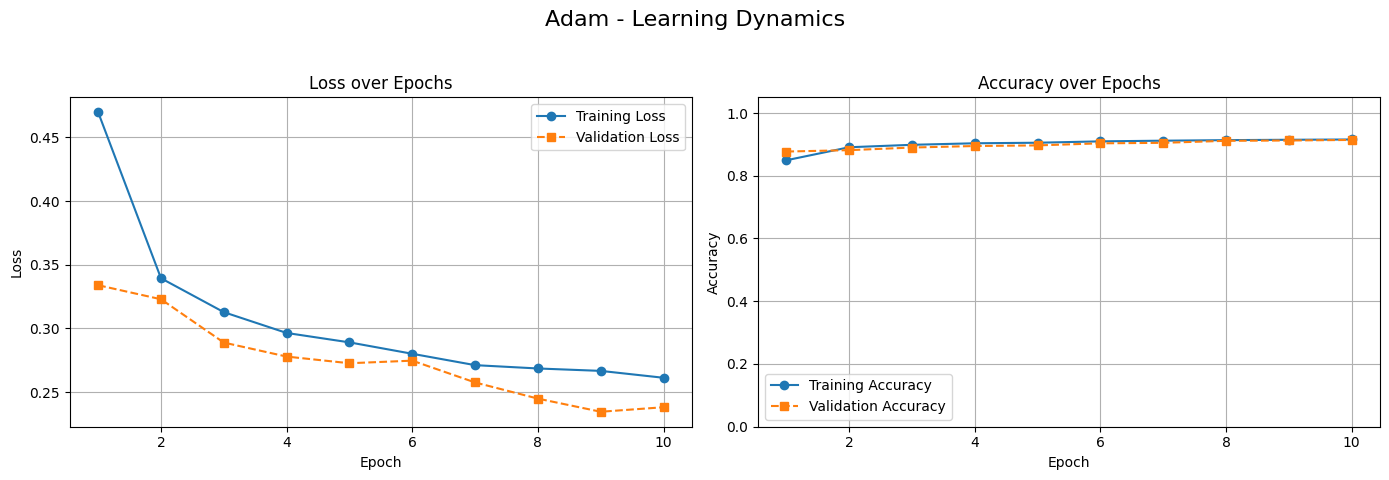

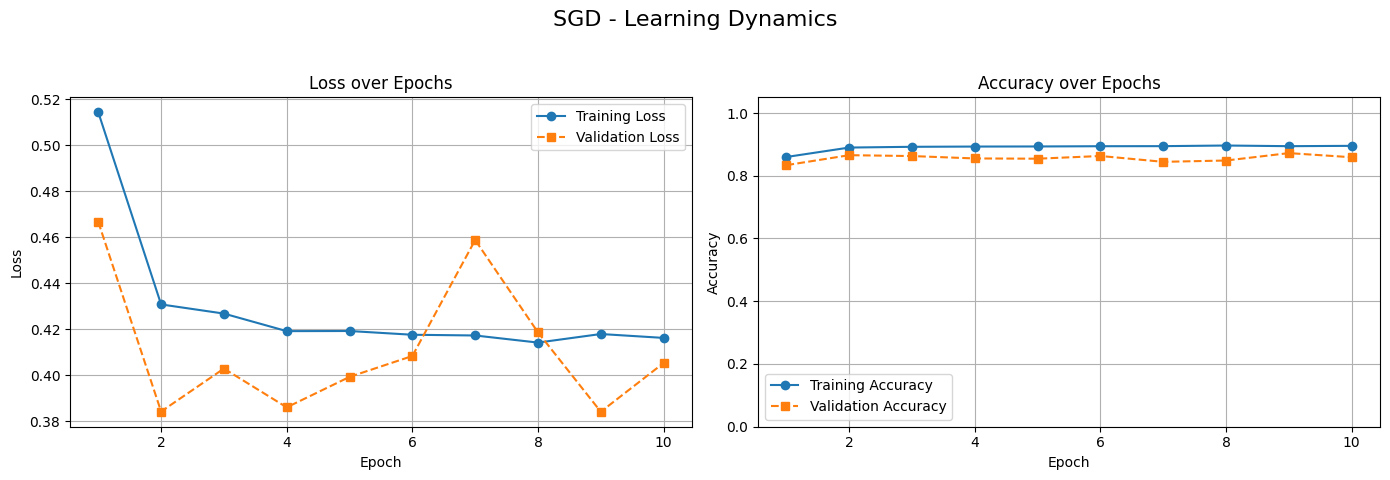

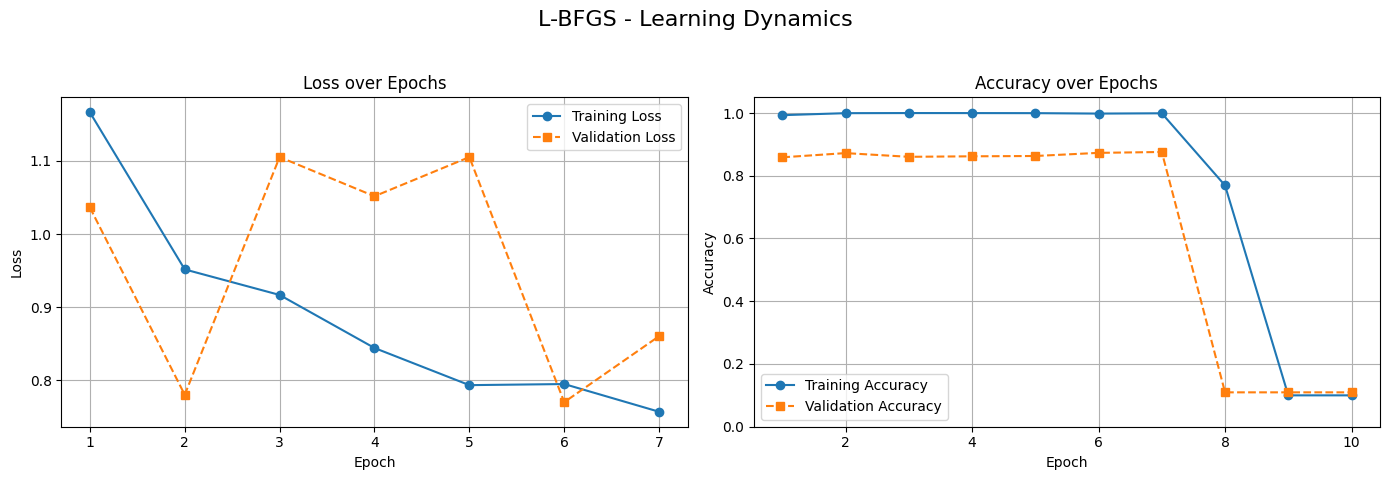

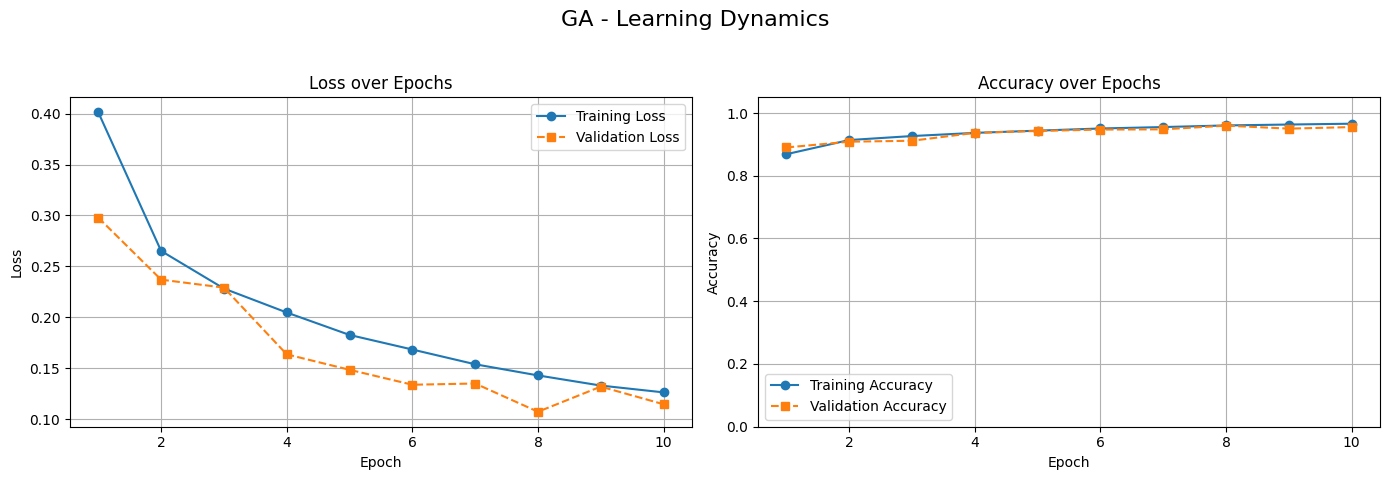

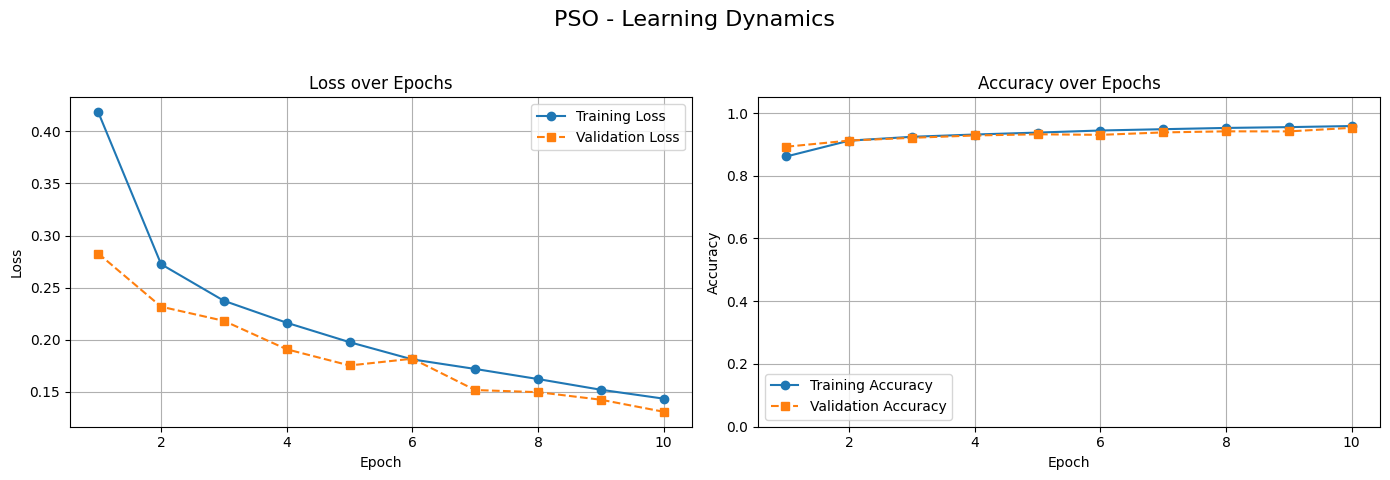


--- Classification Report for Adam ---


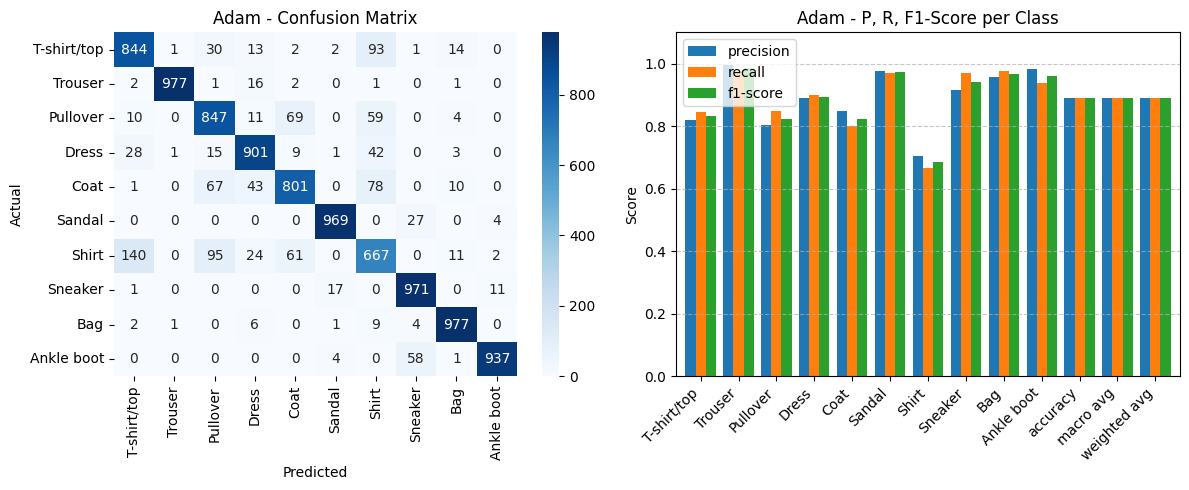


--- Classification Report for SGD ---


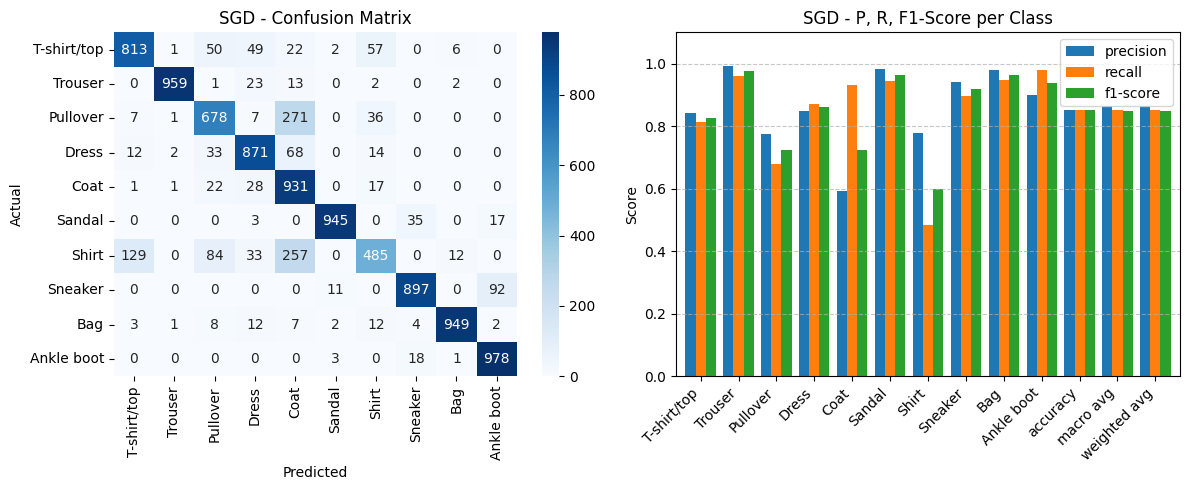


--- Classification Report for L-BFGS ---


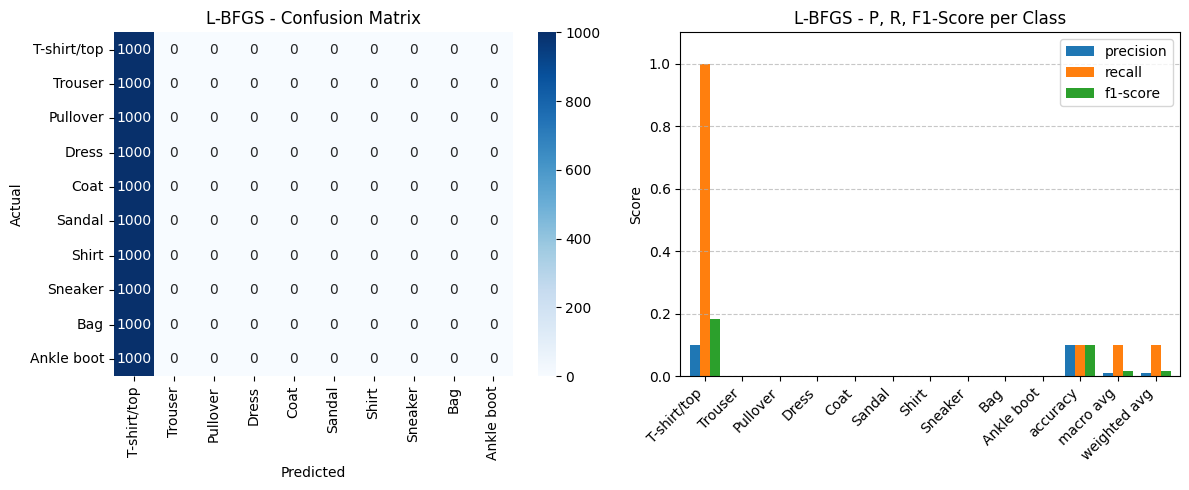


--- Classification Report for GA ---


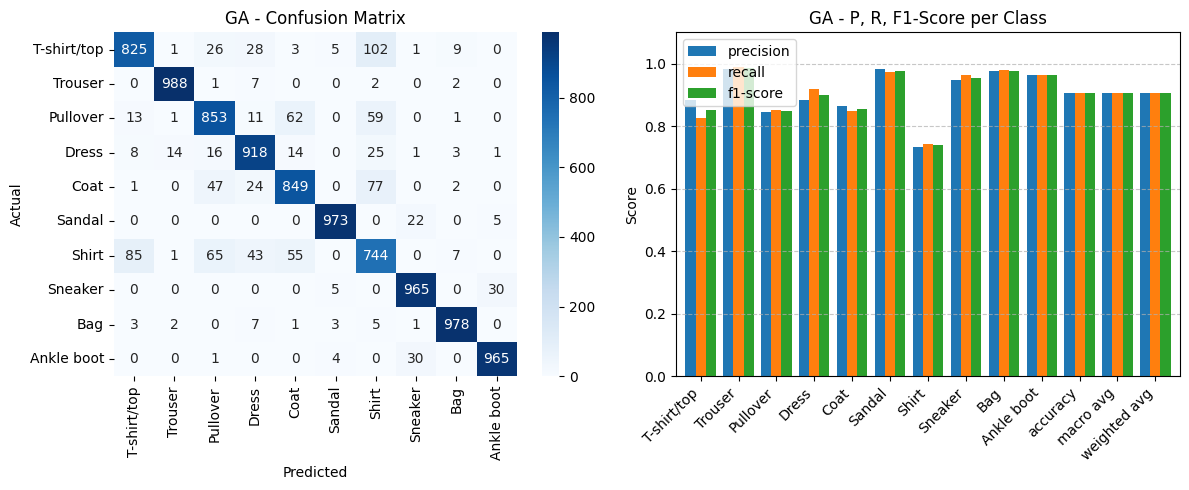


--- Classification Report for PSO ---


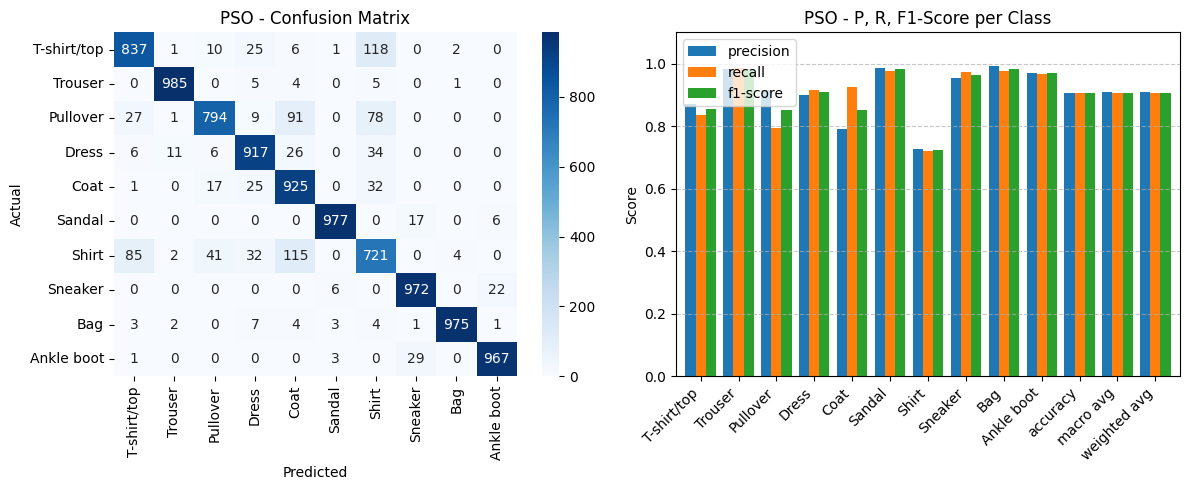

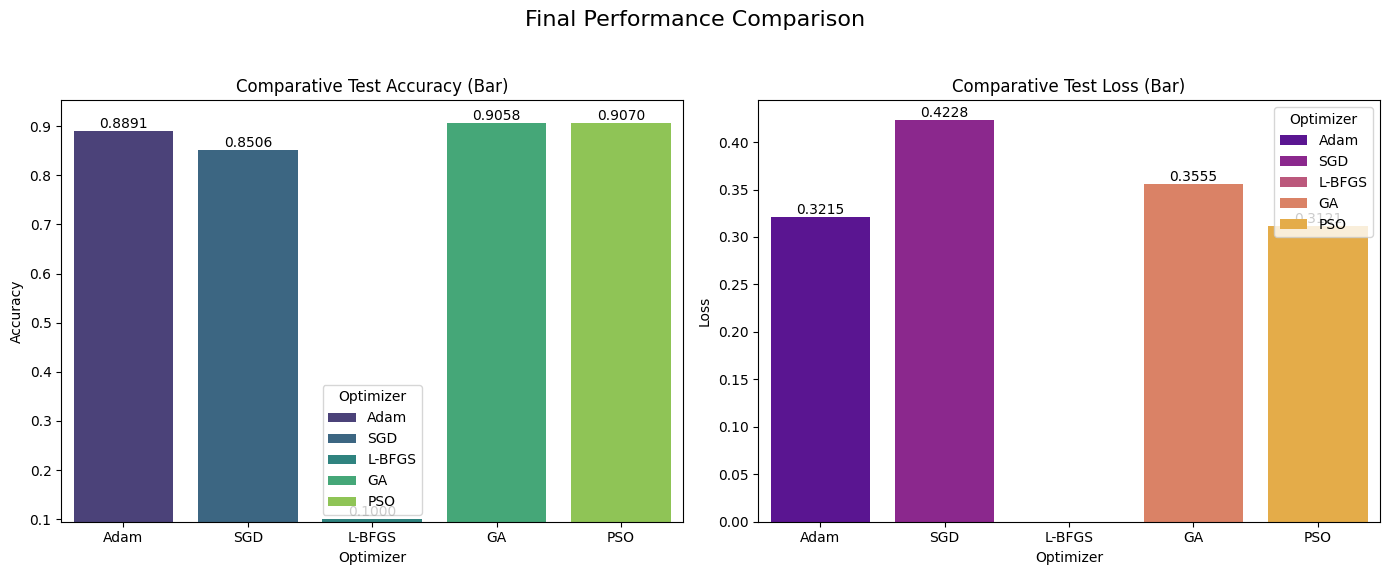

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

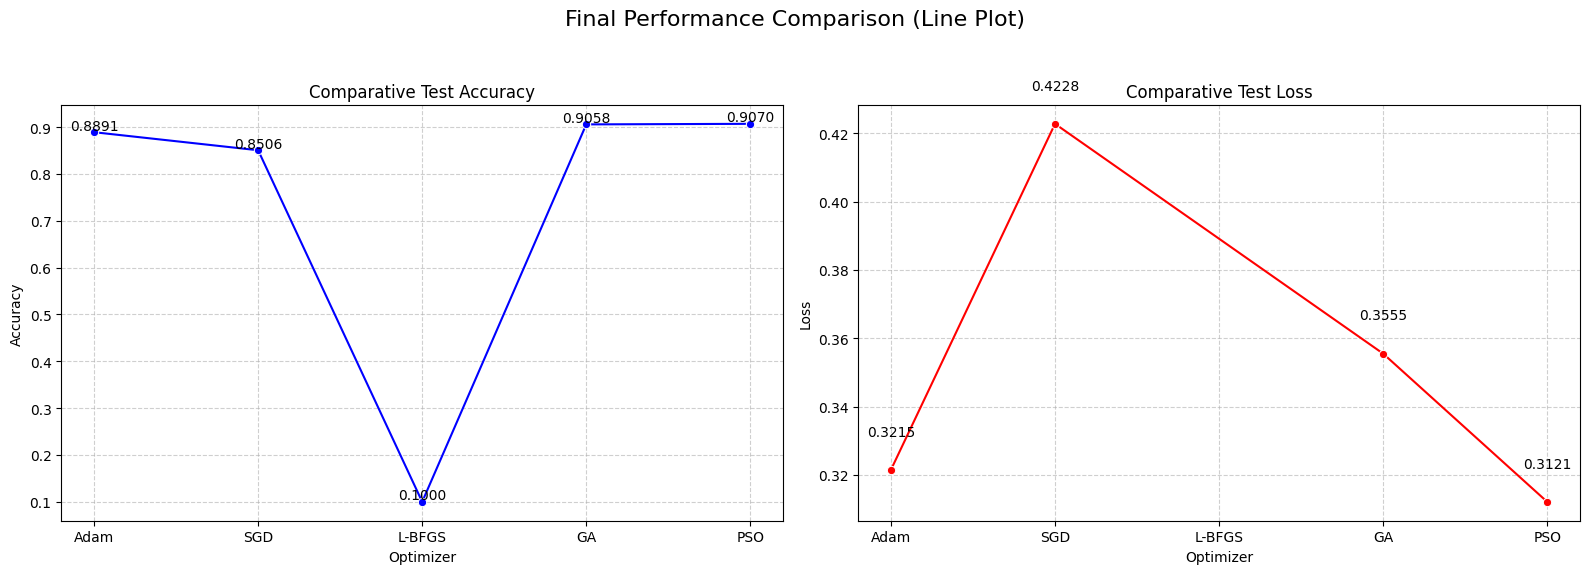

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

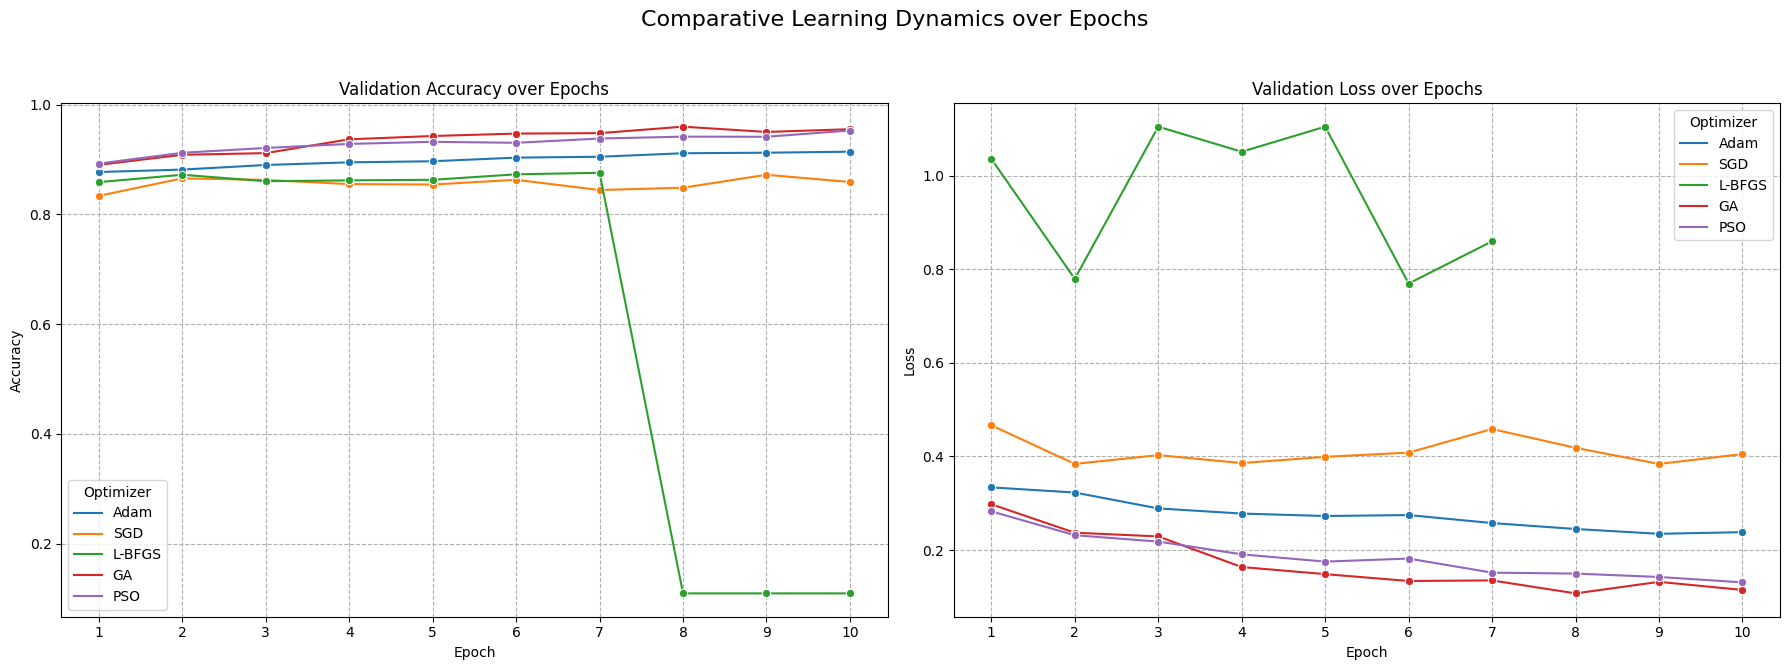

In [ ]:
# 7. MAIN EXECUTION

if __name__ == "__main__":
    # --- Step 1: Run all experiments and store results ---
    results_archive = {}

    results_archive['Adam'] = run_adam_experiment()
    results_archive['SGD'] = run_sgd_experiment()
    results_archive['L-BFGS'] = run_lbfgs_experiment()
    results_archive['GA'] = run_ga_experiment()
    results_archive['PSO'] = run_pso_experiment()

    print("\n✅ All experiments complete. Generating plots...")

    # --- Step 2: Generate all plots from the stored results ---

    plot_learning_curves(results_archive)
    plot_classification_reports(results_archive)
    plot_comparative_results(results_archive)
    plot_comparative_lines(results_archive)
    plot_all_learning_curves_combined(results_archive)